<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Suicide_Ideation/blob/master/V2_XGB_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
!pip install bert-for-tf2

In [33]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os, re, bert, tokenization
import tensorflow_hub as hub
import tensorflow as tf


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
os.environ['KAGGLE_USERNAME'] = "nikhileswarkomati"
os.environ['KAGGLE_KEY'] = "001b3a30170775e55950edb6ff0c9b17"
!kaggle datasets download -d nikhileswarkomati/suicide-watch

 98% 113M/115M [00:04<00:00, 17.6MB/s]
100% 115M/115M [00:04<00:00, 26.5MB/s]


In [5]:
!unzip '/content/suicide-watch.zip'

Archive:  /content/suicide-watch.zip
  inflating: SuicideAndDepression_Detection.csv  


In [55]:
data = pd.read_csv('/content/SuicideAndDepression_Detection.csv', lineterminator = '\n')
data.sample(5)

,text,class
132874,Suicidal due to heartbreak- long storyIf anyon...,SuicideWatch
241074,I don't know if i'm deppressedI read an articl...,depression
9569,StrugglingI’m honestly beginning to wonder if ...,SuicideWatch
49117,"I'm retardedPhysically, mentally, socially",SuicideWatch
273728,"my story! please read...\nhey, so, i figure th...",depression


In [7]:
data.shape

(348111, 2)

In [ ]:
def preprocess(string):
    phrase = str(string)
    phrase = re.sub('[^a-z]+', ' ', phrase, flags = re.IGNORECASE)
    phrase = re.sub('(\s+)', ' ', phrase)
    phrase = phrase.lower()
    # words_li = ['suicide', 'kill', 'depression', 'fuck', 'filler', 'die', 'depressed']
    li = list(stopwords.words()) #+ words_li
    text_tokens = word_tokenize(phrase)
    return " ".join([word for word in text_tokens if word not in li])
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

In [ ]:
data['text'] = data['text'].map(lambda string: preprocess(string))

In [23]:
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

59527144


In [56]:
X = data.iloc[:, 0].values
y = data.iloc[:, 1].values

le = LabelEncoder()

y = le.fit_transform(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, train_size = 0.3)
print(train_X.shape, test_y.shape, val_X.shape)

(83546,) (69623,) (194942,)


In [32]:
clf = Pipeline([('cv', CountVectorizer()), ('xgb', XGBClassifier())])

clf.fit(train_X, train_y)
print("------------Training Done ----------")
predictions = clf.predict(test_X)
print(accuracy_score(predictions, test_y))
print(classification_report(predictions, test_y))

------------Training Done ----------
0.7337230512905218
              precision    recall  f1-score   support

           0       0.64      0.72      0.68     20688
           1       0.66      0.72      0.69     21234
           2       0.90      0.76      0.82     27701

    accuracy                           0.73     69623
   macro avg       0.73      0.73      0.73     69623
weighted avg       0.75      0.73      0.74     69623



In [36]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_X, train_y)


y_pred = nb.predict(test_X)

print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.7153383221062005
              precision    recall  f1-score   support

           0       0.71      0.66      0.68     23126
           1       0.60      0.83      0.69     23176
           2       0.96      0.66      0.78     23321

    accuracy                           0.72     69623
   macro avg       0.76      0.72      0.72     69623
weighted avg       0.76      0.72      0.72     69623



In [37]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])

nb.fit(train_X, train_y)
y_pred = nb.predict(test_X)

print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.7386495841891328
              precision    recall  f1-score   support

           0       0.72      0.65      0.68     23126
           1       0.72      0.66      0.69     23176
           2       0.77      0.90      0.83     23321

    accuracy                           0.74     69623
   macro avg       0.74      0.74      0.73     69623
weighted avg       0.74      0.74      0.73     69623



In [38]:
from sklearn.linear_model import SGDClassifier

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])

nb.fit(train_X, train_y)
y_pred = nb.predict(test_X)

print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.743633569366445
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     23126
           1       0.72      0.67      0.70     23176
           2       0.75      0.93      0.83     23321

    accuracy                           0.74     69623
   macro avg       0.74      0.74      0.74     69623
weighted avg       0.74      0.74      0.74     69623



In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [42]:
import gensim
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [45]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        #logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
for i in range(train_X.shape[0]):
    train_X[i] = w2v_tokenize_text(train_X[i])

for i in range(test_X.shape[0]):
    test_X[i] = w2v_tokenize_text(test_X[i])


In [46]:
X_train_word_average = word_averaging_list(wv,train_X)
X_test_word_average = word_averaging_list(wv,test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


In [47]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, solver = 'newton-cg')
logreg = logreg.fit(X_train_word_average, train_y)
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.7609985206038234
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     23126
           1       0.69      0.75      0.72     23176
           2       0.88      0.86      0.87     23321

    accuracy                           0.76     69623
   macro avg       0.76      0.76      0.76     69623
weighted avg       0.76      0.76      0.76     69623



In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, solver = 'newton-cg')
logreg = logreg.fit(X_train_word_average, train_y)
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.7604239978168134
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     23126
           1       0.69      0.75      0.72     23176
           2       0.88      0.86      0.87     23321

    accuracy                           0.76     69623
   macro avg       0.76      0.76      0.76     69623
weighted avg       0.76      0.76      0.76     69623



In [57]:
import itertools


%matplotlib inline


from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_X) # only fit on train

x_train = tokenize.texts_to_matrix(train_X)
x_test = tokenize.texts_to_matrix(test_X)

num_classes = 3
y_train = utils.to_categorical(train_y, num_classes)
y_test = utils.to_categorical(test_y, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint, earlystopping],
                    validation_split=0.1)


Epoch 1/10
2350/2350 [==============================] - 14s 6ms/step - loss: 0.6271 - accuracy: 0.7320 - val_loss: 0.5264 - val_accuracy: 0.7776

Epoch 00001: val_accuracy improved from -inf to 0.77762, saving model to model.h5
Epoch 2/10
2350/2350 [==============================] - 14s 6ms/step - loss: 0.4889 - accuracy: 0.7940 - val_loss: 0.5104 - val_accuracy: 0.7873

Epoch 00002: val_accuracy improved from 0.77762 to 0.78731, saving model to model.h5
Epoch 3/10
2350/2350 [==============================] - 13s 6ms/step - loss: 0.4473 - accuracy: 0.8138 - val_loss: 0.5092 - val_accuracy: 0.7893

Epoch 00003: val_accuracy improved from 0.78731 to 0.78935, saving model to model.h5
Epoch 4/10
2350/2350 [==============================] - 13s 6ms/step - loss: 0.3972 - accuracy: 0.8371 - val_loss: 0.5191 - val_accuracy: 0.7910

Epoch 00004: val_accuracy improved from 0.78935 to 0.79102, saving model to model.h5
Epoch 5/10
2350/2350 [==============================] - 14s 6ms/step - loss: 0.

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(8, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.6)(net)
    # net = tf.keras.layers.Dense(32, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.5)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
import keras
max_len = 100
train_input = bert_encode(train_X, tokenizer, max_len = max_len)
test_input = bert_encode(test_X, tokenizer, max_len = max_len)
train_labels = train_y

In [ ]:

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split = 0.1,
    epochs = 10,
    callbacks = [checkpoint, earlystopping],
    batch_size = 16,
    verbose = 1)

Epoch 1/10
 5340/17624 [========>.....................] - ETA: 1:10:05 - loss: -9.1857 - accuracy: 0.3786

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
classes = ['SuicideWatch', 'depression', 'teenagers']
for val in classes:
    count = 0
    arr = data.loc[(data['class'] == val), 'text'].values
    
    li = [0] * len(words_li)
    for para in arr:
        i = 0
        for word in words_li:
            li[i] += para.lower().count(word)
            i += 1
    for i in range(len(words_li)):
        print("{} in {} is {} ".format(words_li[i], val, li[i]))

suicide in SuicideWatch is 38031 
kill in SuicideWatch is 53566 
depression in SuicideWatch is 22488 
fuck in SuicideWatch is 65594 
filler in SuicideWatch is 38 
die in SuicideWatch is 49374 
suicide in depression is 16537 
kill in depression is 24343 
depression in depression is 83874 
fuck in depression is 51416 
filler in depression is 44 
die in depression is 23978 
suicide in teenagers is 915 
kill in teenagers is 3835 
depression in teenagers is 1297 
fuck in teenagers is 34342 
filler in teenagers is 62217 
die in teenagers is 6165 


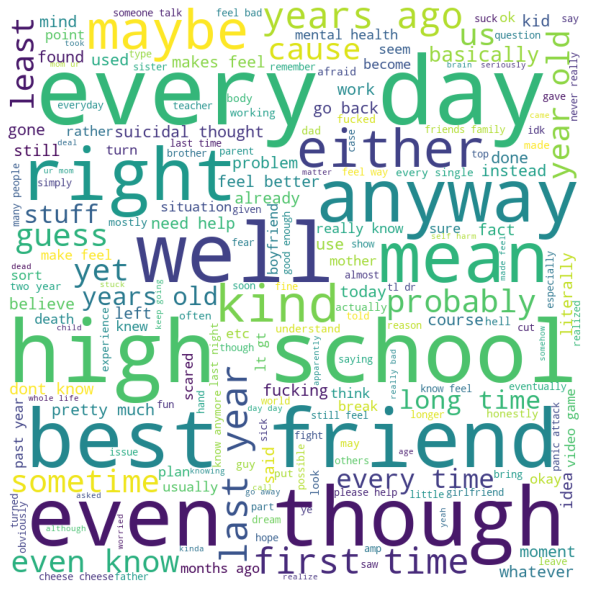

In [ ]:
from wordcloud import WordCloud, STOPWORDS 


# Reads 'Youtube04-Eminem.csv' file 

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in X: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [ ]:
from joblib import dump

# dump the pipeline model
dump(clf, filename = "suicide.joblib")

['suicide.joblib']

In [ ]:
from joblib import load

# sample tweet text
text = ["I'm so depressed"]

# load the saved pipleine model
pipeline = load("/content/suicide.joblib")

# predict on the sample tweet text
pipeline.predict(text)

array([1])

In [ ]:
le.inverse_transform(pipeline.predict(text))

array(['depression'], dtype=object)

In [ ]:
import tweepy
import time
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

# api key
api_key = "YfsfRUtv0Jstlvm0TLg8DrZNA"
# api secret key
api_secret_key = "Dx95SabGPVACrlQanwkajOnsfss0tWsyej8xO8rUKnf6N70Tyh"
# access token
access_token = "704330902432669696-pmTtYoAM3ywia3zAY5sWAEVkzhWUwan"
# access token secret
access_token_secret = "BSW1LmSmDZmNrDPL3KytWXgZeOTHo99Ee1vDu1FBc5EAJ"

# authorize the API Key
authentication = tweepy.OAuthHandler(api_key, api_secret_key)

# authorization to user's access token and access token secret
authentication.set_access_token(access_token, access_token_secret)

# call the api
api = tweepy.API(authentication, wait_on_rate_limit=True)

In [ ]:
def get_related_tweets(text_query):
    # list to store tweets
    tweets_list = []
    # no of tweets
    count = 50
    try:
        # Pulling individual tweets from query
        for tweet in api.search(q=text_query, count=count, lang = 'en'):
            print(tweet.text)
            # Adding to list that contains all tweets
            tweets_list.append({'created_at': tweet.created_at,
                                'tweet_id': tweet.id,
                                'tweet_text': tweet.text})
        return pd.DataFrame.from_dict(tweets_list)

    except BaseException as e:
        print('failed on_status,', str(e))
        time.sleep(3)

In [ ]:
get_related_tweets('suicide')

The most thorough follow-up of sex-reassigned people—extending over 30 years in Sweden - documents their lifelong m… https://t.co/T3IHOzjwwA
RT @Science_social9: I don't know why I feel weak asking this but does anyone have a good resource to share for black men who are seriously…
RT @hasbeemasputra: I look forward to your support in future mental health initiatives Senator @razalidris
 
You can support the mental hea…
RT @jeffgernst: An autopsy finds that the death of Keyla Martinez - who died while in police custody within hours of being detained - was a…
RT @BabySingh99: West Bengal ranks number ONE in 🌾 Vegetable Production.
BJP Sarkar should learn from  @MamataOfficial 🙏 the great CM ever.…
RT @Science_social9: I don't know why I feel weak asking this but does anyone have a good resource to share for black men who are seriously…
RT @Anonymo85632208: SUSHANT DIDN'T COMMITTED SUICIDE

@ips_nupurprasad 

FILE 302 IN SSR MURDER CASE?
RT @Science_social9: I don't know why I feel weak a

,created_at,tweet_id,tweet_text
0,2021-02-10 11:01:13,1359457388735135745,The most thorough follow-up of sex-reassigned people—extending over 30 years in Sweden - documents their lifelong m… https://t.co/T3IHOzjwwA
1,2021-02-10 11:01:11,1359457379411181576,RT @Science_social9: I don't know why I feel weak asking this but does anyone have a good resource to share for black men who are seriously…
2,2021-02-10 11:01:06,1359457359525908480,RT @hasbeemasputra: I look forward to your support in future mental health initiatives Senator @razalidris\n \nYou can support the mental hea…
3,2021-02-10 11:00:54,1359457308196167680,RT @jeffgernst: An autopsy finds that the death of Keyla Martinez - who died while in police custody within hours of being detained - was a…
4,2021-02-10 11:00:53,1359457305671081985,RT @BabySingh99: West Bengal ranks number ONE in 🌾 Vegetable Production.\nBJP Sarkar should learn from @MamataOfficial 🙏 the great CM ever.…
5,2021-02-10 11:00:53,1359457304203186181,RT @Science_social9: I don't know why I feel weak asking this but does anyone have a good resource to share for black men who are seriously…
6,2021-02-10 11:00:52,1359457301350895629,RT @Anonymo85632208: SUSHANT DIDN'T COMMITTED SUICIDE\n\n@ips_nupurprasad \n\nFILE 302 IN SSR MURDER CASE?
7,2021-02-10 11:00:51,1359457295793606661,RT @Science_social9: I don't know why I feel weak asking this but does anyone have a good resource to share for black men who are seriously…
8,2021-02-10 11:00:51,1359457295160250374,VAB's Steering Team is grateful to have recently been given the opportunity to receive Suicide Prevention Training… https://t.co/RoHrXfxfQZ
9,2021-02-10 11:00:47,1359457280169705475,@lapinleader i have the one hour version looped too😭 its way too catchy for a song about depression and suicide


In [ ]:
!python --version

Python 3.6.9


In [ ]:
!pip install xgboost

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'